# Introducción

El modelo principal utilizado en este proyecto es un Random Forest Classifier, una técnica de aprendizaje automático basada en un conjunto de árboles de decisión que permite manejar datos de texto con alta dimensionalidad de manera robusta. A este modelo se le alimentan vectores generados a partir de publicaciones procesadas mediante TF-IDF (frecuencia inversa de documentos) y análisis de sentimiento. Previo a esto, se realiza un proceso completo de limpieza, normalización, lematización del texto y codificación de las variables objetivo.

Dado que este proyecto se enfoca en el análisis de salud mental, específicamente en la detección de contenido relacionado con anorexia, se seleccionaron métricas de evaluación que priorizan la identificación correcta de casos de riesgo, evitando omitir señales importantes.

Una de las métricas clave es el AUC (Área bajo la curva ROC), que permite evaluar la capacidad del modelo para diferenciar entre casos positivos (anorexia) y negativos (control), sin verse afectada por un posible desbalance de clases. Esta métrica es especialmente valiosa en contextos clínicos, donde los falsos negativos pueden tener consecuencias serias.

También se pone especial atención al recall, que mide qué tan bien el modelo identifica todos los casos positivos. En este tipo de problema, es fundamental reducir al mínimo los falsos negativos, ya que dejar pasar un caso real de anorexia puede implicar riesgos significativos.

La precisión ayuda a entender qué tan confiables son las predicciones positivas del modelo: es decir, de todos los casos que clasificó como "anorexia", cuántos realmente lo eran. Esto es importante para evitar generar alarmas falsas.

Finalmente, se utiliza el F1 score como métrica balanceada entre precisión y recall, ideal para problemas donde ambas métricas son relevantes y deben sopesarse de forma conjunta.

# Importación de Librerías

In [ ]:
!pip install xgboost

In [ ]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import train_test_split

# Exploración de información

In [ ]:
data = pd.read_csv('data_train(in).csv')

In [ ]:
data.head()

,user_id,tweet_id,tweet_text,class
0,user0001,0d3ed29586ce,Cheesecake saludable sin azúcar y sin lactosa ...,control
1,user0002,c3cf897a495b,ser como ellas ♡♡\n #HastaLosHuesos,anorexia
2,user0003,5041d85c45c6,"Comida Real o , la clave para estar más sana, ...",control
3,user0004,d18285d3c7ec,Entre el cambio de hora y la bajada de las #te...,control
4,user0005,4d81892f3217,Hace mucho tiempo no sentía mi cuerpo tan frío,anorexia


In [ ]:
data.tweet_text.value_counts()

,count
tweet_text,
1er día\n* Dos latas de coca cola light \n* Litro & medio de agua pura\n* Tres tazas de té sin azúcar...\n\n #ayuno #Ana #Princesa,1
Cheesecake saludable sin azúcar y sin lactosa con mermerlada casera de moras,1
ser como ellas ♡♡\n #HastaLosHuesos,1
"Comida Real o , la clave para estar más sana, delgada y feliz \n\nhttps://www.modalia.es/estilo-de-vida/15192-comida-real-o-real-food-la-clave-para-estar-mas-sana-delgada-y-feliz.html …",1
"Entre el cambio de hora y la bajada de las #temperaturas estamos destemplados, por eso os recomendamos un buen plato de #fabada #casera para entonar el cuerpo #decasa #platoscuchara #madridrio #gastro #arganzuela",1
...,...
Cambiar la comida por el alcohol,1
Norex Anfepromona un potente medicamento para dejar de comer en exceso\nADELGAZA SIN HAMBRE\n#TusClásicos #SabadoDeGanarSeguidores #EsPuenteYTodos #bellezasuperior\n#TwitterBestFandom\n#SoompiAwards\n#ConvoyVL19\n#20anosVL19 #Tampico #Dieta #Obesidad #Madero #Tamaulipas #Fit,1
"Los huesos que se me notan, son la copa, la medalla, por haberte ganado la batalla.\n.",1


# Limpieza de datos

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

In [ ]:
!python -m spacy download es_core_news_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 25.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy

nlp = spacy.load('es_core_news_sm')

def clean_text_lemmatization(text):
    """
    Funciona que limpia y lematiza un texto en español aplicando los siguientes pasos:

    1. Convierte el texto a minúsculas
    2. Elimina URLs (http, https, www)
    3. Quita el símbolo '#'
    4. Elimina caracteres especiales
    5. Elimina espacios duplicados
    6. Aplica lematización con spaCy y remueve stopwords

    Parámetros:
        text (str): Texto original a procesar.

    Retorna:
        str: Texto limpio y lematizado, separado por espacios.
    """
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"#(\w+)", r"\1", text)
    text = re.sub(r"[^a-záéíóúñü\s]", '', text)
    text = re.sub(r"\s+", ' ', text).strip()

    doc = nlp(text)
    lemmatized_tokens = [
        token.lemma_ for token in doc if not token.is_stop
    ]

    return ' '.join(lemmatized_tokens)

data['clean_text_lemma'] = data['tweet_text'].apply(clean_text_lemmatization)


In [ ]:
data.head()

,user_id,tweet_id,tweet_text,class,clean_text_lemma
0,user0001,0d3ed29586ce,Cheesecake saludable sin azúcar y sin lactosa ...,control,cheesecakir saludable azúcar lactosa mermerlad...
1,user0002,c3cf897a495b,ser como ellas ♡♡\n #HastaLosHuesos,anorexia,hastaloshueso
2,user0003,5041d85c45c6,"Comida Real o , la clave para estar más sana, ...",control,comida real clave sano delgado feliz
3,user0004,d18285d3c7ec,Entre el cambio de hora y la bajada de las #te...,control,cambio hora bajada temperatura destemplado rec...
4,user0005,4d81892f3217,Hace mucho tiempo no sentía mi cuerpo tan frío,anorexia,tiempo sentir cuerpo frío


In [ ]:
X_text = data['clean_text_lemma']


In [ ]:
X_text

,clean_text_lemma
0,cheesecakir saludable azúcar lactosa mermerlad...
1,hastaloshueso
2,comida real clave sano delgado feliz
3,cambio hora bajada temperatura destemplado rec...
4,tiempo sentir cuerpo frío
...,...
1495,desayuno sano ricocomidasán metodohappy
1496,perfección sábado án abandona thinspo thinspir...
1497,comer devolver caloría tengoundeseoyes perfeccion
1498,entender seguir soltero cocino masterchef demi...


In [ ]:
import xgboost as xgb
from sklearn.linear_model import LogisticRegression as LR
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np

# Preparación de Datos

In [ ]:
def preparar_datos(data):
    """
    Función que realiza la preparación inicial del dataset:
    - Calcula el promedio de letras por tweet.
    - Convierte etiquetas 'control' y 'anorexia' en 0 y 1.
    - Extrae las variables X (entrada) e y (etiqueta).

    Parámetros:
        data (DataFrame): DataFrame original con columnas 'clean_text_lemma' y 'class'.

    Retorna:
        X (DataFrame): Solo la columna 'clean_text_lemma'.
        y (Series): Etiquetas codificadas como 0 y 1.
    """
    avg_letters = data['clean_text_lemma'].apply(lambda x: len(str(x).replace(" ", ""))).mean()
    print(f"Promedio de letras por tweet: {avg_letters:.2f}")

    data['class'] = data['class'].map({'control': 0, 'anorexia': 1})
    y = data["class"]
    X = data[["clean_text_lemma"]].copy()

    return X, y

X, y = preparar_datos(data)

Promedio de letras por tweet: 71.95


In [ ]:
X

,clean_text_lemma
0,cheesecakir saludable azúcar lactosa mermerlad...
1,hastaloshueso
2,comida real clave sano delgado feliz
3,cambio hora bajada temperatura destemplado rec...
4,tiempo sentir cuerpo frío
...,...
1495,desayuno sano ricocomidasán metodohappy
1496,perfección sábado án abandona thinspo thinspir...
1497,comer devolver caloría tengoundeseoyes perfeccion
1498,entender seguir soltero cocino masterchef demi...


In [ ]:
y

,class
0,0
1,1
2,0
3,0
4,1
...,...
1495,0
1496,1
1497,1
1498,0


# Sentiment Analysis y Vectorizer

In [ ]:
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import numpy as np

def vectorizar_con_sentimiento(X_text, ngram_range=(1, 2), max_features=2000, amplify_sentiment=True):
    """
    Función que vectoriza el texto con TF-IDF (usando n-grams) y añade una columna de sentiment analysis usando normalización y escalado

    Parámetros:
        X_text (pd.Series): Serie de texto limpio
        ngram_range (tuple): Rango de n-gramas para usar en TF-IDF
        max_features (int): Número de caracteres
        amplify_sentiment (bool): Si True, multiplica el sentimiento normalizado escalado por 3, para amplificar el impacto

    Regresa:
        X: matriz final combinada con sentimiento
        vectorizer: El vectorizador entrenado
    """
    sentiment_scores = X_text.apply(lambda text: TextBlob(str(text)).sentiment.polarity)
    sentiment_scores = sentiment_scores.apply(lambda x: (x + 1) / 2)
    if amplify_sentiment:
        sentiment_scores *= 3

    vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
    X_tfidf = vectorizer.fit_transform(X_text)

    sentiment_column = np.array(sentiment_scores).reshape(-1, 1)
    X_final = hstack([X_tfidf, sentiment_column])

    return X_final, vectorizer

X_final, vectorizer = vectorizar_con_sentimiento(X["clean_text_lemma"])

In [ ]:
X_final_csr = X_final.tocsr()

In [ ]:
print(X_final_csr[:5].toarray())

[[0.  0.  0.  ... 0.  0.  1.5]
 [0.  0.  0.  ... 0.  0.  1.5]
 [0.  0.  0.  ... 0.  0.  1.8]
 [0.  0.  0.  ... 0.  0.  1.5]
 [0.  0.  0.  ... 0.  0.  1.5]]


# Separación de datos

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# Búsqueda de Hiperparámetros y Entrenamiento con Best Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer, f1_score

# Modelo base
clf = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

# Rejilla de hiperparámetros
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Validación cruzada con KFold
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring=make_scorer(f1_score),
    cv=cv,
    verbose=1,
    n_jobs=-1
)

# Entrenamiento
grid_search.fit(X_train, y_train)

# Resultados
print("Mejores hiperparámetros:", grid_search.best_params_)
best_model = grid_search.best_estimator_


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Mejores hiperparámetros: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [ ]:
print("Mejores hiperparámetros:", grid_search.best_params_)

Mejores hiperparámetros: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


In [ ]:
best_model = grid_search.best_estimator_

# Entrenamiento manual

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    max_features='log2',
    min_samples_leaf=1,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

clf.fit(X_train, y_train)


RandomForestClassifier(max_features='log2', min_samples_split=5,
                       n_estimators=200, n_jobs=-1, random_state=42)

# Métricas de Evaluación

AUC: 0.9614

Classification Report:
              precision    recall  f1-score   support

     control       0.92      0.82      0.86       141
    anorexia       0.85      0.94      0.89       159

    accuracy                           0.88       300
   macro avg       0.89      0.88      0.88       300
weighted avg       0.88      0.88      0.88       300



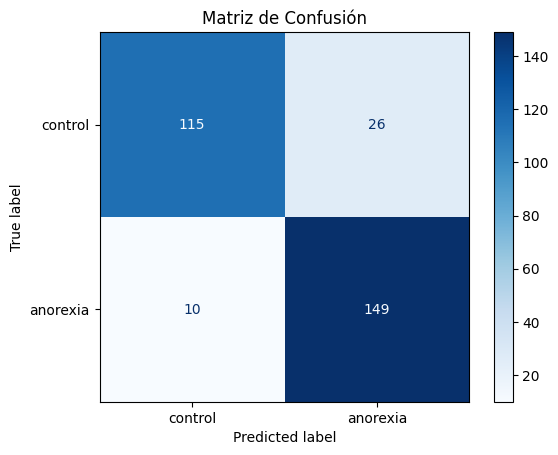

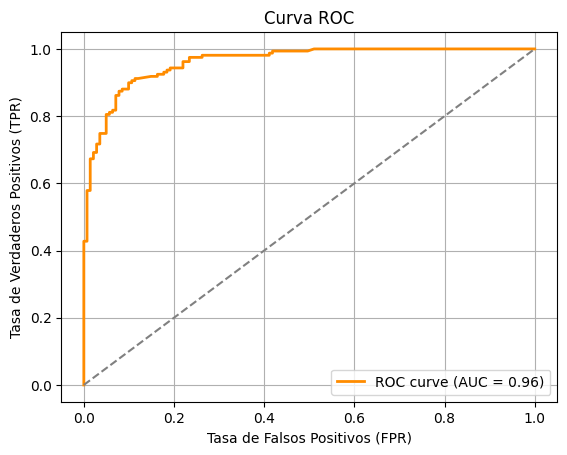

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import seaborn as sns

def evaluar_modelo_con_graficas(clf, X_test, y_test):
    """
    Función que evalúa el modelo:
    - AUC
    - Reporte de clasificación
    - Matriz de confusión
    - Curva ROC

    Parámetros:
    - clf: modelo entrenado
    - X_test: features de prueba
    - y_test: etiquetas verdaderas
    """

    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_prob)
    print(f"AUC: {auc:.4f}")

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=["control", "anorexia"]))

    conf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=["control", "anorexia"])
    disp.plot(cmap="Blues")
    plt.title("Matriz de Confusión")
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {auc:.2f})")
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title('Curva ROC')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

evaluar_modelo_con_graficas(clf, X_test, y_test)

# Test con datos nuevos

In [ ]:
import pandas as pd

test_fold1 = pd.read_csv("/content/data_test_fold1 - anorexia(in).csv")

In [ ]:
test_fold1["clean_text_lemma"] = test_fold1["tweet_text"].apply(clean_text_lemmatization)

In [ ]:
test_fold1.head()

,user_id,tweet_id,tweet_text,class,clean_text_lemma
0,user1501,a2ffa2b1425c,A ver cuando se empiezan con las de anorexia y...,anorexia,empezar anorexia bulimia fácil acceder
1,user1503,bfdce07b546c,"¡7 días, 7 razones para entrenar!\n-\nLlegamos...",control,razón entrenar llegar domingo wow acabar seman...
2,user1506,fdcb32f44ce7,Como bajar peso comiendo sin parar.\n #Tips,anorexia,bajar peso comer parar tip
3,user1508,17203fc43352,"No importa si ese platillo luce bien,delicioso...",anorexia,importar platillo lucir biendeliciosoricoeso m...
4,user1509,3947b6578c8e,Por supuesto el polo es de fruta y casero\n\nM...,control,polo fruta casero frase patatar sano cuidar él...


In [ ]:
X_f1, y_f1 = preparar_datos(test_fold1)

Promedio de letras por tweet: 68.42


In [ ]:
X_f1

,clean_text_lemma
0,empezar anorexia bulimia fácil acceder
1,razón entrenar llegar domingo wow acabar seman...
2,bajar peso comer parar tip
3,importar platillo lucir biendeliciosoricoeso m...
4,polo fruta casero frase patatar sano cuidar él...
...,...
245,whatsapp escondite comunidad anorexia bulimio
246,barbyaranda anaymiar querer cuerpo
247,desayuno martes empezar acabar adelgazar lowca...
248,querer necesito desear thinspiration


In [ ]:
y_f1

,class
0,1
1,0
2,1
3,1
4,0
...,...
245,0
246,1
247,0
248,1


In [ ]:
sentiment_scores = X_f1["clean_text_lemma"].apply(lambda text: TextBlob(str(text)).sentiment.polarity)
sentiment_scores = sentiment_scores.apply(lambda x: (x + 1) / 2) * 3

X_tfidf_f1 = vectorizer.transform(X_f1["clean_text_lemma"])
X_f1_final = hstack([X_tfidf_f1, np.array(sentiment_scores).reshape(-1, 1)])

AUC: 0.9091

Classification Report:
              precision    recall  f1-score   support

     control       0.87      0.68      0.76       116
    anorexia       0.77      0.91      0.83       134

    accuracy                           0.80       250
   macro avg       0.82      0.80      0.80       250
weighted avg       0.81      0.80      0.80       250



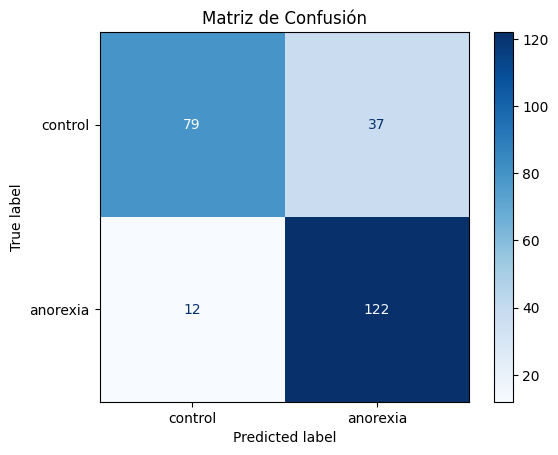

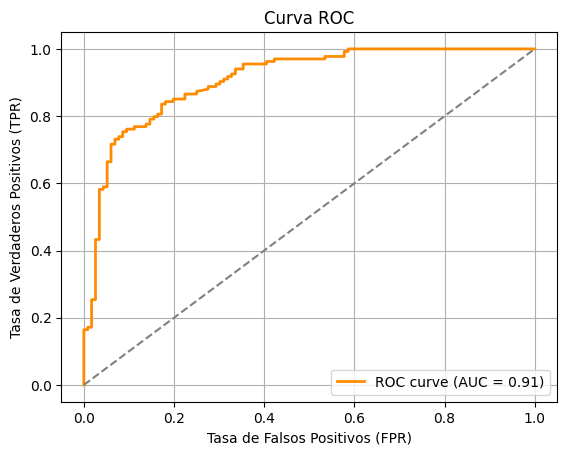

In [ ]:
evaluar_modelo_con_graficas(clf, X_f1_final, y_f1)

# Pruebas Unitarias

Para garantizar la funcionalidad, confiabilidad y calidad del código desarrollado para el procesamiento y modelado de texto, se implementaron pruebas unitarias

In [ ]:
import unittest


class TestCleanText(unittest.TestCase):

    def test_quitar_url(self):
        self.assertNotIn("http", clean_text_lemmatization("visita https://ejemplo.com"))

    def test_lower(self):
        result = clean_text_lemmatization("HOLA MUNDO")
        self.assertEqual(result, result.lower())

    def test_sin_puntuacion(self):
        result = clean_text_lemmatization("¡Hola, mundo!")
        self.assertNotIn("¡", result)
        self.assertNotIn(",", result)

    def test_lemmatizacion(self):
        result = clean_text_lemmatization("Estoy corriendo al parque")
        self.assertIn("correr", result)

    def test_stopwords_fuera(self):
        result = clean_text_lemmatization("Ella es la mejor")
        self.assertNotIn("ella" or "es" or "la", result)

    def test_hashtags(self):
        result = clean_text_lemmatization("Estoy #Motivado")
        self.assertIn("motivado", result)
        self.assertNotIn("#", result)

    def test_entrada_numerica(self):
        result = clean_text_lemmatization(123456)
        self.assertEqual(result, "")

    def test_espacios(self):
        result = clean_text_lemmatization("   hola     mundo    ")
        self.assertNotIn("  ", result)

unittest.main(argv=[''], verbosity=2, exit=False)


test_entrada_numerica (__main__.TestCleanText.test_entrada_numerica) ... ok
test_espacios (__main__.TestCleanText.test_espacios) ... ok
test_hashtags (__main__.TestCleanText.test_hashtags) ... ok
test_lemmatizacion (__main__.TestCleanText.test_lemmatizacion) ... ok
test_lower (__main__.TestCleanText.test_lower) ... ok
test_quitar_url (__main__.TestCleanText.test_quitar_url) ... ok
test_sin_puntuacion (__main__.TestCleanText.test_sin_puntuacion) ... ok
test_stopwords_fuera (__main__.TestCleanText.test_stopwords_fuera) ... ok

----------------------------------------------------------------------
Ran 8 tests in 0.262s

OK


In [ ]:
class TestPrepararDatos(unittest.TestCase):

    def setUp(self):
        self.data = pd.DataFrame({
            'clean_text_lemma': ['me gusta comer', 'comer poco adelgazar', 'feliz adelgazar comer sano'],
            'class': ['control', 'anorexia', 'anorexia']
        })

    def test_map_clases_correctamente(self):
        _, y = preparar_datos(self.data.copy())
        self.assertListEqual(sorted(y.dropna().unique().tolist()), [0, 1])

    def test_output_formato_correcto(self):
        X, y = preparar_datos(self.data.copy())
        self.assertTrue(isinstance(X, pd.DataFrame))
        self.assertTrue(isinstance(y, pd.Series))
        self.assertEqual(X.shape[0], 3)
        self.assertEqual(y.shape[0], 3)
        self.assertIn('clean_text_lemma', X.columns)

    def test_promedio_letras(self):
      data_2 = self.data.copy()
      letras_esperadas = data_2['clean_text_lemma'].apply(lambda x: len(str(x).replace(" ", ""))).mean()
      preparar_datos(data_2)
      letras_obtenidas = data_2['clean_text_lemma'].apply(lambda x: len(str(x).replace(" ", ""))).mean()
      self.assertAlmostEqual(letras_obtenidas, letras_esperadas, places=2)


unittest.main(argv=[''], verbosity=2, exit=False)

test_entrada_numerica (__main__.TestCleanText.test_entrada_numerica) ... ok
test_espacios (__main__.TestCleanText.test_espacios) ... ok
test_hashtags (__main__.TestCleanText.test_hashtags) ... ok
test_lemmatizacion (__main__.TestCleanText.test_lemmatizacion) ... ok
test_lower (__main__.TestCleanText.test_lower) ... ok
test_quitar_url (__main__.TestCleanText.test_quitar_url) ... ok
test_sin_puntuacion (__main__.TestCleanText.test_sin_puntuacion) ... ok
test_stopwords_fuera (__main__.TestCleanText.test_stopwords_fuera) ... ok
test_map_clases_correctamente (__main__.TestPrepararDatos.test_map_clases_correctamente) ... ok
test_output_formato_correcto (__main__.TestPrepararDatos.test_output_formato_correcto) ... ok
test_promedio_letras (__main__.TestPrepararDatos.test_promedio_letras) ... ok

----------------------------------------------------------------------
Ran 11 tests in 0.438s

OK


Promedio de letras por tweet: 17.67
Promedio de letras por tweet: 17.67
Promedio de letras por tweet: 17.67


In [ ]:
from numpy import ndarray

class TestVectorizarConSentimiento(unittest.TestCase):

    def setUp(self):
        self.X_text = pd.Series([
            "comer sano feliz",
            "odio mi cuerpo",
            "me siento normal"
        ])

    def test_vectorizer_devuelto(self):
        _, vectorizer = vectorizar_con_sentimiento(self.X_text)
        self.assertIsNotNone(vectorizer)
        self.assertTrue(hasattr(vectorizer, 'transform'))

        def test_sentimiento_amplificado(self): # Se Transforma el X para que se
          X_final_amp, _ = vectorizar_con_sentimiento(self.X_text, amplify_sentiment=True)
          X_final_std, _ = vectorizar_con_sentimiento(self.X_text, amplify_sentiment=False)

          X_final_amp = X_final_amp.tocsr()
          X_final_std = X_final_std.tocsr()

          col_amp = X_final_amp[:, -1].toarray()
          col_std = X_final_std[:, -1].toarray()

          self.assertTrue((col_amp > col_std).all())


    def test_dimensiones_correctas(self):
        X_final, vectorizer = vectorizar_con_sentimiento(self.X_text, max_features=10)
        self.assertEqual(X_final.shape[0], 3)
        self.assertEqual(X_final.shape[1], 11)


unittest.main(argv=[''], verbosity=2, exit=False)

test_entrada_numerica (__main__.TestCleanText.test_entrada_numerica) ... ok
test_espacios (__main__.TestCleanText.test_espacios) ... ok
test_hashtags (__main__.TestCleanText.test_hashtags) ... ok
test_lemmatizacion (__main__.TestCleanText.test_lemmatizacion) ... ok
test_lower (__main__.TestCleanText.test_lower) ... ok
test_quitar_url (__main__.TestCleanText.test_quitar_url) ... ok
test_sin_puntuacion (__main__.TestCleanText.test_sin_puntuacion) ... ok
test_stopwords_fuera (__main__.TestCleanText.test_stopwords_fuera) ... ok
test_map_clases_correctamente (__main__.TestPrepararDatos.test_map_clases_correctamente) ... ok
test_output_formato_correcto (__main__.TestPrepararDatos.test_output_formato_correcto) ... ok
test_promedio_letras (__main__.TestPrepararDatos.test_promedio_letras) ... ok
test_dimensiones_correctas (__main__.TestVectorizarConSentimiento.test_dimensiones_correctas) ... ok
test_vectorizer_devuelto (__main__.TestVectorizarConSentimiento.test_vectorizer_devuelto) ... ok

---

Promedio de letras por tweet: 17.67
Promedio de letras por tweet: 17.67
Promedio de letras por tweet: 17.67


test_entrada_numerica (__main__.TestCleanText.test_entrada_numerica) ... ok
test_espacios (__main__.TestCleanText.test_espacios) ... ok
test_hashtags (__main__.TestCleanText.test_hashtags) ... ok
test_lemmatizacion (__main__.TestCleanText.test_lemmatizacion) ... ok
test_lower (__main__.TestCleanText.test_lower) ... ok
test_quitar_url (__main__.TestCleanText.test_quitar_url) ... ok
test_sin_puntuacion (__main__.TestCleanText.test_sin_puntuacion) ... ok
test_stopwords_fuera (__main__.TestCleanText.test_stopwords_fuera) ... ok
test_funcion_evaluacion_sin_error (__main__.TestEvaluacionModelo.test_funcion_evaluacion_sin_error) ... 

AUC: 0.8937

Classification Report:
              precision    recall  f1-score   support

     control       0.93      0.77      0.84        35
    anorexia       0.74      0.92      0.82        25

    accuracy                           0.83        60
   macro avg       0.84      0.85      0.83        60
weighted avg       0.85      0.83      0.83        60



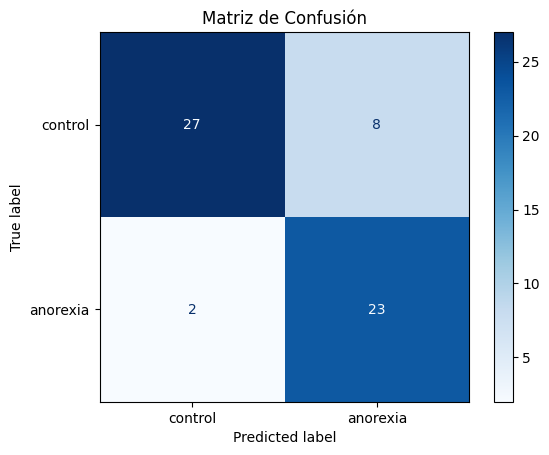

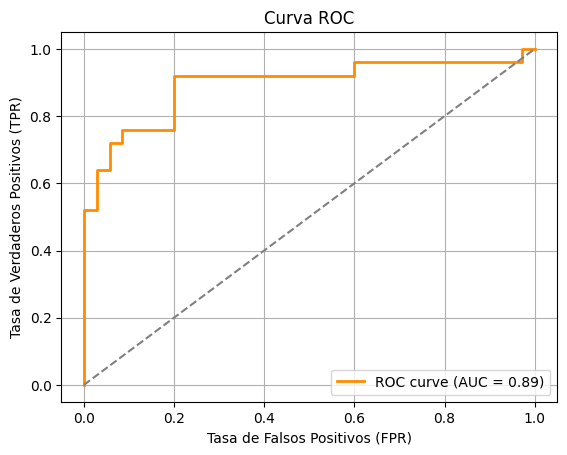

ok
test_predicciones_no_nulas (__main__.TestEvaluacionModelo.test_predicciones_no_nulas) ... ok
test_probabilidades_validas (__main__.TestEvaluacionModelo.test_probabilidades_validas) ... ok
test_map_clases_correctamente (__main__.TestPrepararDatos.test_map_clases_correctamente) ... ok
test_output_formato_correcto (__main__.TestPrepararDatos.test_output_formato_correcto) ... ok
test_promedio_letras (__main__.TestPrepararDatos.test_promedio_letras) ... ok
test_dimensiones_correctas (__main__.TestVectorizarConSentimiento.test_dimensiones_correctas) ... ok
test_vectorizer_devuelto (__main__.TestVectorizarConSentimiento.test_vectorizer_devuelto) ... ok

----------------------------------------------------------------------
Ran 16 tests in 1.396s

OK


Promedio de letras por tweet: 17.67
Promedio de letras por tweet: 17.67
Promedio de letras por tweet: 17.67


In [ ]:
import warnings
from sklearn.datasets import make_classification

warnings.filterwarnings("ignore")

class TestEvaluacionModelo(unittest.TestCase):

    @classmethod
    def setUpClass(cls):
        X, y = make_classification(
            n_samples=200,
            n_features=20,
            n_informative=10,
            n_redundant=5,
            random_state=42
        )
        cls.X_train, cls.X_test, cls.y_train, cls.y_test = train_test_split(
            X, y, test_size=0.3, random_state=42
        )

        cls.clf = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
        cls.clf.fit(cls.X_train, cls.y_train)


    def test_predicciones_no_nulas(self):
        y_pred = self.clf.predict(self.X_test)
        self.assertEqual(len(y_pred), len(self.y_test))
        self.assertIn(y_pred[0], [0, 1])

    def test_probabilidades_validas(self):
        y_prob = self.clf.predict_proba(self.X_test)
        self.assertEqual(y_prob.shape[1], 2)
        self.assertTrue((y_prob >= 0).all() and (y_prob <= 1).all())

    def test_funcion_evaluacion_sin_error(self):
        try:
            evaluar_modelo_con_graficas(self.clf, self.X_test, self.y_test)
        except Exception as e:
            self.fail(f"La función evaluar_modelo_con_graficas lanzó un error inesperado: {e}")

if __name__ == "__main__":
    unittest.main(argv=[''], verbosity=2, exit=False)
